## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score, recall_score
from torch.utils.data import DataLoader
from tqdm import tqdm

# Setup Paths
sys.path.append('..')
from src.config import config
from src.dataset import HAM10000Dataset
from src.transforms import get_transforms
from src.models import get_model

print(f"Device: {config.DEVICE}")
print(f"Evaluating Model: {config.BASE_MODEL}")

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
Device: mps
Evaluating Model: resnet50_cbam_tuned


## Load Test Data

In [2]:
# 1. Load Test Data
test_ds = HAM10000Dataset(
    config.PROCESSED_DATA_DIR / 'test.csv', 
    transform=get_transforms('val')
)

# shuffle=False เพราะเราต้องการลำดับที่ถูกต้องเวลาเทียบกับ Label
test_loader = DataLoader(
    test_ds, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=config.NUM_WORKERS
)

print(f" Test Set Loaded: {len(test_ds)} images")

 Test Set Loaded: 1497 images


## Load Best Model Weights

In [3]:
# 2. Initialize Model
device = config.DEVICE
model = get_model(device=device)

# 3. Load Best Weights
# ชื่อไฟล์จะเปลี่ยนไปตาม config.BASE_MODEL (resnet50 หรือ efficientnet_b0)
checkpoint_path = config.CHECKPOINT_DIR / f'best_model_{config.BASE_MODEL}.pth'

if checkpoint_path.exists():
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f" Successfully loaded best model from: {checkpoint_path}")
else:
    print(f" Error: Checkpoint not found at {checkpoint_path}")
    print("   Please check config.BASE_MODEL or train the model first.")

 Building Model: ResNet50 | CBAM=True
 Successfully loaded best model from: /Users/mati/adv_skin_cancer/models/checkpoints/best_model_resnet50_cbam_tuned.pth


## Run Inference (Prediction Loop)

In [4]:
# 4. Inference Loop
model.eval()
y_true = []
y_pred = []
y_prob = [] # เก็บค่าความน่าจะเป็น (เผื่อใช้ในอนาคต)

print("Running inference on test set...")

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        outputs = model(images)
        
        # Get probabilities & predictions
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        # Store results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

print("Inference complete.")

Running inference on test set...


Predicting: 100%|███████████████████████████████| 47/47 [00:15<00:00,  4.25it/s]

✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created
✓ SkinCancerClassification v1.0.0
Note: Other modules will be loaded as they are created


Predicting: 100%|███████████████████████████████| 47/47 [00:35<00:00,  1.33it/s]

Inference complete.


## Calculate Key Metrics

In [5]:
print("="*30)
print(f" EVALUATION RESULTS: {config.BASE_MODEL}")
print("="*30)

# 4.1 Macro F1-Score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f" Macro F1-Score:      {macro_f1:.4f}")

# 4.2 Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f" Balanced Accuracy:   {balanced_acc:.4f}")

# 4.3 Melanoma Recall (Specific Class)
if 'mel' in config.CLASS_TO_IDX:
    mel_idx = config.CLASS_TO_IDX['mel']
    recalls = recall_score(y_true, y_pred, average=None)
    mel_recall = recalls[mel_idx]
    print(f" Melanoma Recall:     {mel_recall:.4f}")
else:
    print(" Class 'mel' not found in config.")

print("-" * 30)

 EVALUATION RESULTS: resnet50_cbam_tuned
 Macro F1-Score:      0.7164
 Balanced Accuracy:   0.6976
 Melanoma Recall:     0.5714
------------------------------


## Detailed Classification Report

In [6]:
# 5. Full Report
target_names = [config.IDX_TO_CLASS[i] for i in range(len(config.CLASS_NAMES))]

# เพิ่ม zero_division=0 เพื่อจัดการกับตัวหารที่เป็น 0
report = classification_report(
    y_true, 
    y_pred, 
    target_names=target_names, 
    digits=4,
    zero_division=0  # <--- ใส่เพิ่มตรงนี้ครับ
)

print("\n Detailed Classification Report:")
print(report)


 Detailed Classification Report:
              precision    recall  f1-score   support

       akiec     0.5821    0.7647    0.6610        51
         bcc     0.7568    0.7273    0.7417        77
         bkl     0.6712    0.6242    0.6469       157
          df     0.8333    0.4545    0.5882        22
         mel     0.6575    0.5714    0.6115       168
          nv     0.8944    0.9230    0.9085      1000
        vasc     0.9000    0.8182    0.8571        22

    accuracy                         0.8283      1497
   macro avg     0.7565    0.6976    0.7164      1497
weighted avg     0.8259    0.8283    0.8252      1497



## Confusion Matrix Visualization

 Saved confusion matrix to: /Users/mati/adv_skin_cancer/reports/figures/confusion_matrix_resnet50_cbam_tuned.png


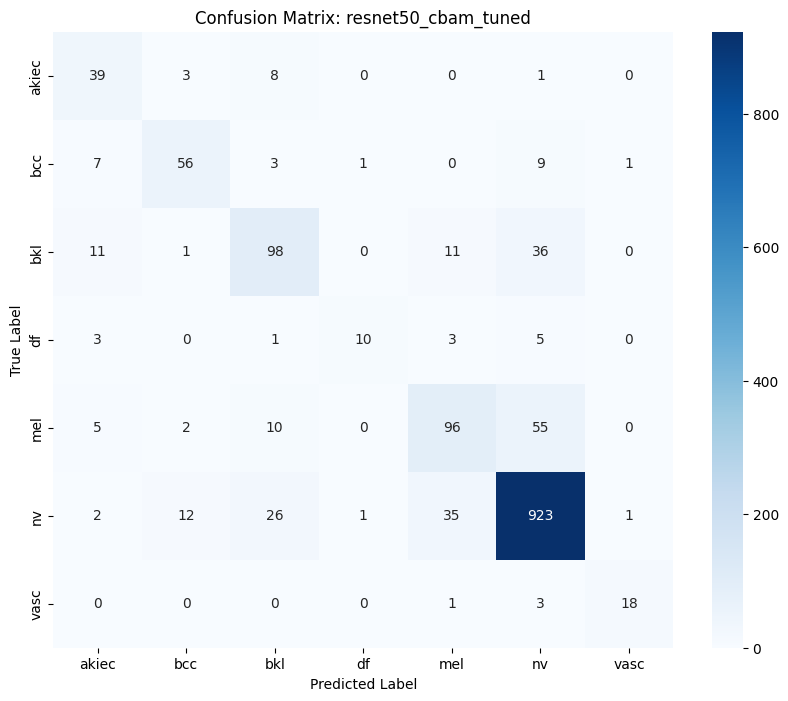

In [7]:
# 6. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=target_names, 
    yticklabels=target_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: {config.BASE_MODEL}')

# Save Figure
save_path = config.FIGURE_DIR / f'confusion_matrix_{config.BASE_MODEL}.png'
plt.savefig(save_path)
print(f" Saved confusion matrix to: {save_path}")

plt.show()